In [453]:
import pandas as pd
import numpy as np
from quantitative_finance.utils.bonds.coupon_bond import CouponBond

In [454]:
def price_bond(face_value, coupon_rate, ytm, years_to_maturity, frequency=1):
    """
    Calculates the price of a bond based on its future cash flows and yield to maturity.

    Parameters:
    - face_value: The bond's face value (par value).
    - coupon_rate: The annual coupon rate of the bond as a decimal (e.g., 5% as 0.05).
    - ytm: The bond's yield to maturity as a decimal.
    - years_to_maturity: The number of years until the bond matures.
    - frequency: The number of coupon payments per year.

    Returns:
    - The price of the bond as a float.
    """
    coupon_payment = face_value * coupon_rate / frequency
    periods = years_to_maturity * frequency
    discount_rates = (1 + ytm / frequency) ** np.arange(1, periods + 1)
    coupon_payments_pv = np.sum(coupon_payment / discount_rates)
    face_value_pv = face_value / (1 + ytm / frequency) ** periods
    bond_price = coupon_payments_pv + face_value_pv
    return bond_price

def calculate_duration(face_value, coupon_rate, ytm, years_to_maturity, frequency=1, modified=True):
    bond_price = price_bond(
        face_value=face_value,
        coupon_rate=coupon_rate,
        ytm=ytm,
        years_to_maturity=years_to_maturity,
        frequency=frequency
    )
    total_time_periods = years_to_maturity * frequency
    time_periods = np.arange(1, total_time_periods + 1)
    discount_factors = (1 + ytm / frequency) ** time_periods  # Correct discount rate calculation
    coupon_payment = face_value * coupon_rate / frequency
    cash_flows = np.full(total_time_periods, coupon_payment)
    cash_flows[-1] += face_value  # Add the face value to the last payment

    # Correctly discount and weight the cash flows
    discounted_cash_flows = cash_flows / discount_factors
    weighted_discounted_cash_flows = discounted_cash_flows * time_periods
    duration = np.sum(weighted_discounted_cash_flows) / bond_price

    if modified:
        duration = duration / (1 + ytm / frequency)

    return duration

In [455]:
YIELD_CURVE_SHIFT_FACTOR = 0.01
SHIFT_PERCENT = True
FLATTEN_YIELD_CURVE = False
FIRST_PERIOD_RATE = 0.02
MAX_MATURITY = 30
MATURITIES = np.arange(1, MAX_MATURITY + 1, 1)
TOTAL_YEARS = 30
TOTAL_YEARS_ARR = np.arange(0, TOTAL_YEARS + 1, 1)

BOND_MATURITY = 10
PAR_VALUE = 1_000
COUPON = 0.1
COUPON_GROWTH_RATE = 0
FREQUENCY = 1

# Yield Curve

In [456]:
yield_curve_shift_arr = TOTAL_YEARS_ARR * YIELD_CURVE_SHIFT_FACTOR


yield_curve_shape_arr = np.log10(MATURITIES, ) if not FLATTEN_YIELD_CURVE else 0
yield_curve_df = pd.DataFrame(data=FIRST_PERIOD_RATE, index=MATURITIES, columns=TOTAL_YEARS_ARR)
yield_curve_df = yield_curve_df.multiply(yield_curve_shape_arr + 1, axis=0)

if SHIFT_PERCENT:
    yield_curve_df = yield_curve_df.multiply(yield_curve_shift_arr + 1, axis=1)
else:
    yield_curve_df = yield_curve_df.add(yield_curve_shift_arr, axis=1)

<Axes: >

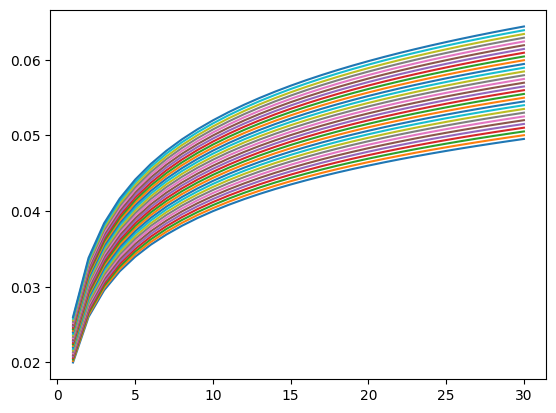

In [457]:
yield_curve_df.plot(legend=False)

In [458]:
bond_names = [f'Bond {x}' for x in range(1, BOND_MATURITY + 1)]
bond_default_df = pd.DataFrame(index=TOTAL_YEARS_ARR, columns=bond_names)

# Maturities

In [459]:
maturity_pattern_arr = np.arange(BOND_MATURITY, 0, -1)

# Use broadcasting to fill in the matrix
indices = np.arange(TOTAL_YEARS + 1)[:, None] + np.arange(BOND_MATURITY)
wrapped_indices = np.mod(indices, BOND_MATURITY)

# Fill the matrix using the wrapped indices to repeat the maturity pattern
maturity_matrix = maturity_pattern_arr[wrapped_indices]

maturity_df = bond_default_df.copy()
maturity_df.loc[:, :] = maturity_matrix

# Prices

In [460]:
coupon_df = bond_default_df.copy()
coupon_df.loc[:, :] = COUPON * PAR_VALUE
price_df = bond_default_df.copy()
face_value_df = bond_default_df.copy()
face_value_df.loc[:, :] = 0
repurchase_df = bond_default_df.copy()
repurchase_df.loc[:, :] = 0

for index in maturity_df.index:
    for col in maturity_df.columns:
        maturity = maturity_df.loc[index, col]
        bond_price = price_bond(
            face_value=PAR_VALUE,
            coupon_rate=COUPON,
            ytm=yield_curve_df.loc[BOND_MATURITY, index],
            years_to_maturity=maturity,
            frequency=FREQUENCY
        )
        price_df.loc[index, col] = bond_price
        
        if maturity == BOND_MATURITY:
            face_value_df.loc[index, col] = PAR_VALUE
            repurchase_df.loc[index, col] = bond_price

coupon_df = coupon_df.iloc[1:, :]
face_value_df = face_value_df.iloc[1:, :]
repurchase_df = repurchase_df.iloc[1:, :]

In [461]:
price_dollar_return_df = (price_df - price_df.shift()).dropna()
roll_dollar_return = face_value_df - repurchase_df

In [462]:
total_dollar_return = price_dollar_return_df + roll_dollar_return + coupon_df

In [463]:
price_dollar_return_df.sum(axis=1)

1    -22.968988
2      -22.9045
3     -22.84024
4    -22.776208
5    -22.712401
6     -22.64882
7    -22.585463
8     -22.52233
9    -22.459419
10    -22.39673
11   -22.334261
12   -22.272012
13   -22.209982
14    -22.14817
15   -22.086575
16   -22.025197
17   -21.964033
18   -21.903084
19   -21.842349
20   -21.781826
21   -21.721515
22   -21.661415
23   -21.601525
24   -21.541844
25   -21.482372
26   -21.423107
27   -21.364049
28   -21.305196
29   -21.246548
30   -21.188105
dtype: object

In [464]:
roll_dollar_return.sum(axis=1)

1    -482.448231
2     -478.25846
3    -474.084365
4    -469.925878
5    -465.782932
6    -461.655461
7    -457.543396
8    -453.446673
9    -449.365225
10   -445.298986
11    -441.24789
12   -437.211874
13   -433.190871
14   -429.184818
15   -425.193649
16   -421.217302
17   -417.255713
18   -413.308818
19   -409.376555
20    -405.45886
21   -401.555672
22   -397.666928
23   -393.792567
24   -389.932527
25   -386.086746
26   -382.255165
27   -378.437722
28   -374.634357
29    -370.84501
30   -367.069621
dtype: object

In [465]:
total_dollar_return

,Bond 1,Bond 2,Bond 3,Bond 4,Bond 5,Bond 6,Bond 7,Bond 8,Bond 9,Bond 10
1,55.685393,54.489745,53.229578,51.901639,50.502515,49.028627,47.476228,45.841385,44.119979,42.307692
2,54.925979,53.663894,52.333625,50.931715,49.454538,47.898296,46.259002,44.532477,42.714341,56.123174
3,54.095928,52.763587,51.359156,49.878964,48.31916,46.675704,44.944357,43.120676,56.558181,55.359681
4,53.191533,51.784845,50.30191,48.738824,47.091493,45.355621,43.5267,56.99043,55.790865,54.525692
5,52.20879,50.72338,49.157291,47.506373,45.76627,43.932412,57.419937,56.219545,54.953196,53.617473
6,51.14338,49.574564,47.920343,46.176304,44.337812,57.84672,56.645734,55.378451,54.041416,52.630996
7,49.990646,48.333408,46.585725,44.742901,58.270793,57.069445,55.801469,54.463369,53.05147,51.561914
8,48.745567,46.994534,45.147679,58.692173,57.490692,56.222261,54.883342,53.47022,51.978988,50.405541
9,47.402732,45.552147,59.110876,57.909488,56.640836,55.301344,53.887251,52.394605,50.819253,49.156825
10,45.956305,59.526916,58.325847,57.057207,55.717382,54.30257,52.808772,51.231784,49.567182,47.810319


In [466]:
total_dollar_return.sum(axis=1) / price_df.iloc[:-1, :].sum(axis=1).values

1     0.038538
2     0.038939
3      0.03934
4     0.039741
5     0.040143
6     0.040544
7     0.040945
8     0.041346
9     0.041747
10    0.042149
11     0.04255
12    0.042951
13    0.043352
14    0.043753
15    0.044154
16    0.044556
17    0.044957
18    0.045358
19    0.045759
20     0.04616
21    0.046561
22    0.046963
23    0.047364
24    0.047765
25    0.048166
26    0.048567
27    0.048968
28     0.04937
29    0.049771
30    0.050172
dtype: object

In [467]:
price_df

,Bond 1,Bond 2,Bond 3,Bond 4,Bond 5,Bond 6,Bond 7,Bond 8,Bond 9,Bond 10
0,1486.653747,1446.119897,1403.964692,1360.12328,1314.528211,1267.10934,1217.793713,1166.505462,1113.16568,1057.692308
1,1442.33914,1400.609641,1357.194271,1312.024919,1265.030726,1216.137967,1165.269941,1112.346847,1057.285659,1482.448231
2,1397.265119,1354.273535,1309.527896,1262.956634,1214.485264,1164.036263,1111.528943,1056.879324,1478.25846,1438.571405
3,1351.361047,1307.037122,1260.887052,1212.835598,1162.804425,1110.711967,1056.4733,1474.084365,1434.816641,1393.931086
4,1304.55258,1258.821968,1211.188961,1161.574422,1109.895918,1056.067588,1469.925878,1431.074795,1390.607506,1348.456778
5,1256.76137,1209.545348,1160.346252,1109.080795,1055.662188,1465.782932,1427.345815,1387.29434,1345.560702,1302.074251
6,1207.90475,1159.119911,1108.266595,1055.257099,1461.655461,1423.629652,1383.991549,1342.672791,1299.602117,1254.705247
7,1157.895396,1107.453319,1054.852321,1457.543396,1419.926254,1380.699097,1339.793019,1297.13616,1252.653588,1206.267161
8,1106.640963,1054.447853,1453.446673,1416.235569,1377.416946,1336.921358,1294.676361,1250.60638,1204.632575,1156.672702
9,1054.043695,1449.365225,1412.557549,1374.145058,1334.057782,1292.222702,1248.563611,1203.000985,1155.451828,1105.829528
